
We all know that coronavirus is spreading on a daily basis in India. So, let's try to visualise how fast it is spreading.

First, let's look at the dashboard created by Johns Hopkins University. You can look at the following live dashboard to see the real-time trend.

[COVID-19 Live Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)

Now, let's create a similar map for India using Python to visualise the most affected states in India due to coronavirus. After the class, you can share it with your parents, relatives and friends by sending them the link to the map.

---

In [ ]:
# Download data
!git clone https://github.com/CSSEGISandData/COVID-19.git

# Install 'geocoder'
!pip install geocoder

# Importing modules
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime 
import geocoder
import folium
from folium import plugins 

# DataFrame for the world
conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
conf_df = pd.read_csv(conf_csv)
grouped_conf_df = conf_df.groupby(by = ['Country/Region'], as_index = False).sum()

# DataFrame for India
india_df = pd.read_csv("https://api.covid19india.org/csv/latest/state_wise.csv")
india_df = india_df.iloc[1:, :]
state_latitudes = []
state_longitudes = []
for i in india_df.index:
    state = india_df['State'][i]
    state_lat = geocoder.osm(state).lat
    state_lng = geocoder.osm(state).lng
    state_latitudes.append(state_lat)
    state_longitudes.append(state_lng)

state_latitudes = pd.Series(data = state_latitudes, index = india_df.index)
state_longitudes = pd.Series(data = state_longitudes, index = india_df.index)
india_df['Latitude'] = state_latitudes
india_df['Longitude'] = state_longitudes

# DataFrame for the US
us_conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_conf_df = pd.read_csv(us_conf_csv)
us_conf_df = us_conf_df.dropna()
grouped_us_conf_df = us_conf_df.groupby(by = ['Combined_Key'], as_index = False).sum()

# Function to get total confirmed cases in a country
def get_total_confirmed_cases_for_country(country_name):
    total_cases_country = conf_df[conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_cases_country.index = pd.to_datetime(total_cases_country.index)
    return total_cases_country

# Function to get total confirmed cases in the world
def get_total_confirmed_global_cases():
    global_cases = conf_df.iloc[:, 4:].apply(sum, axis=0)
    global_cases.index = pd.to_datetime(global_cases.index)
    return global_cases

# Function to create a line plot
def line_plot(your_name, plot_background, fig_width, fig_height, country_name, colour, linewidth, markertype):
    dt_series = None
    if country_name != 'global':
        dt_series = get_total_confirmed_cases_for_country(country_name)
    else:
        dt_series = get_total_confirmed_global_cases()
    plt.style.use(plot_background)
    plt.figure(figsize = (fig_width, fig_height))
    plt.title(f'{country_name.upper()}: Total Coronavirus Cases Reported\nCreated by {your_name.upper()}', fontsize = 16)
    plt.plot(dt_series.index, dt_series, c = colour, lw = linewidth, marker = markertype, markersize = 7)
    plt.xticks(rotation = 45)
    plt.ylabel("Total Cases")
    plt.grid(linestyle='--', c='grey')
    plt.show()

# Add minimap
def add_minimap(map_name):
    # Plugin for mini map
    minimap = plugins.MiniMap(toggle_display = True)
    map_name.add_child(minimap) # Add minimap
    plugins.ScrollZoomToggler().add_to(map_name) # Add scroll zoom toggler to map
    plugins.Fullscreen(position='topright').add_to(map_name) # Add full screen button to map

# Add title to map
def add_title(map_name, country, your_name):
    title_html = '''
        <h2 align="center" style="font-size:20px"><b>Coronavirus Total Confirmed Cases in {}</b></h2>
        <h4 align="center" style="font-size:16px"><i>Created by</i> {}</h4>
        </h4>
             '''.format(country, your_name.upper())   
    return map_name.get_root().html.add_child(folium.Element(title_html))

# Function to create folium maps using for India, US and the world
def folium_map_with_circles(your_name, country, map_width, map_height, left_margin, top_margin, map_tile, zoom, circle_color, minimap):
    last_col = conf_df.columns[-1]
    if country == 'India':
        india_map = folium.Map(location = [22.3511148, 78.6677428], 
                               width = map_width, height = map_height,
                               left = f"{left_margin}%", top = f"{top_margin}%",
                               tiles = map_tile, zoom_start = zoom)
        
        if minimap == True:
            add_minimap(india_map)
    
        add_title(india_map, country, your_name)    
        for i in india_df.index:
            folium.Circle(radius = float(india_df.loc[i, 'Confirmed']) / 1.25,
                          location = [india_df.loc[i, 'Latitude'], india_df.loc[i, 'Longitude']],
                          popup = "{}\n {}\n on {}".format(india_df.loc[i, 'State'], 
                                                          india_df.loc[i, 'Confirmed'], 
                                                          india_df.loc[i, 'Last_Updated_Time']),
                          
                          color = circle_color,
                          fill = True).add_to(india_map)
        return india_map

    elif country == 'US':
        us_map = folium.Map(location = [39.381266, -97.922211], 
                            width = map_width, height = map_height, 
                            left = f"{left_margin}%", top = f"{top_margin}%",
                            tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(us_map)
        
        add_title(us_map, country, your_name)
        for i in grouped_us_conf_df.index:
            folium.Circle(location = [grouped_us_conf_df.loc[i, 'Lat'], grouped_us_conf_df.loc[i, 'Long_']], 
                          radius = int(grouped_us_conf_df.loc[i, last_col]), 
                          popup = "{}\n {}\n on {}".format(grouped_us_conf_df.loc[i, 'Combined_Key'],
                                                          grouped_us_conf_df.loc[i, last_col],
                                                          last_col),
                          color = circle_color,
                          fill = True).add_to(us_map)
        return us_map
    
    elif country == 'World':
        world_map = folium.Map(location = [0, 0], 
                            width = map_width, height = map_height, 
                            left = f"{left_margin}%", top = f"{top_margin}%",
                            tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(world_map)
        
        add_title(world_map, country, your_name)
        for i in grouped_conf_df.index:
            folium.Circle(location = [grouped_conf_df.loc[i, 'Lat'], grouped_conf_df.loc[i, 'Long']], 
                          radius = int(grouped_conf_df.loc[i, last_col]) / 2, 
                          popup = "{}\n {}\n on {}".format(grouped_conf_df.loc[i, 'Country/Region'],
                                                          grouped_conf_df.loc[i, last_col], 
                                                          last_col),
                          color = circle_color, 
                          fill = True).add_to(world_map)
        return world_map
    else:
        print("\nWrong input! Enter either India, US or World.\n")

# Total confirmed cases in the descending order.
grouped_conf_df = conf_df.groupby(by='Country/Region', as_index=False).sum()
desc_grp_conf_df = grouped_conf_df.sort_values(by=conf_df.columns[-1], ascending=False)

# Function to create a bar plot displaying the top 10 countries having the most number of coronavirus confirmed cases.
def bar_plot(your_name, num_countries, width, height):
    last_col = conf_df.columns[-1]
    latest_date = datetime.datetime.strptime(last_col, '%m/%d/%y').strftime('%B %d, %Y') # Modify the latest date in the 'Month DD, YYYY' format.
    plt.figure(figsize = (width, height))
    plt.title(f'Top {num_countries} Countries with Highest COVID-19 Confirmed Cases\nCreated by {your_name.upper()}',fontsize = 16)
    sns.barplot(desc_grp_conf_df[last_col].head(num_countries), desc_grp_conf_df['Country/Region'].head(num_countries), orient = 'h')
    plt.xlabel(f'Total Confirmed Cases (in millions) as of {latest_date}')
    plt.show()

# Non-cumulative Confirmed Cases.
non_cum_conf_df = desc_grp_conf_df.iloc[:, :4]
for i in range(len(desc_grp_conf_df.columns[3:]) - 1):
    series = desc_grp_conf_df[desc_grp_conf_df.columns[3 + (i + 1) ]] - desc_grp_conf_df[desc_grp_conf_df.columns[3 + i]]
    non_cum_conf_df[desc_grp_conf_df.columns[3 + (i + 1)]] = series

# Function to get the total non-cumulative confirmed cases in a country.
def get_total_daily_confirmed_cases_for_country(country_name):
    total_daily_cases = non_cum_conf_df[non_cum_conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_daily_cases.index = pd.to_datetime(total_daily_cases.index)
    return total_daily_cases

# Line plot for the daily (non-cumulative) confirmed cases in various countries.
def daily_cases_line_plot(your_name, num_countries, width, height):
    plt.figure(figsize=(width, height))
    plt.title(f'Non-Cumulative COVID-19 Confirmed Cases\nCreated by {your_name.upper()}', fontsize = 16)
    for region in non_cum_conf_df.iloc[:num_countries, :]['Country/Region']:
        total_conf_cases = get_total_daily_confirmed_cases_for_country(region)
        plt.plot(total_conf_cases.index[53:], total_conf_cases[53:], lw=2.5, label=region)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid('major', linestyle='--', c='grey')
    plt.show()

fatal: destination path 'COVID-19' already exists and is not an empty directory.


---

In [ ]:
conf_df[conf_df['Country/Region'] == 'World']

Empty DataFrame
Columns: [Province/State, Country/Region, Lat, Long, 1/22/20, 1/23/20, 1/24/20, 1/25/20, 1/26/20, 1/27/20, 1/28/20, 1/29/20, 1/30/20, 1/31/20, 2/1/20, 2/2/20, 2/3/20, 2/4/20, 2/5/20, 2/6/20, 2/7/20, 2/8/20, 2/9/20, 2/10/20, 2/11/20, 2/12/20, 2/13/20, 2/14/20, 2/15/20, 2/16/20, 2/17/20, 2/18/20, 2/19/20, 2/20/20, 2/21/20, 2/22/20, 2/23/20, 2/24/20, 2/25/20, 2/26/20, 2/27/20, 2/28/20, 2/29/20, 3/1/20, 3/2/20, 3/3/20, 3/4/20, 3/5/20, 3/6/20, 3/7/20, 3/8/20, 3/9/20, 3/10/20, 3/11/20, 3/12/20, 3/13/20, 3/14/20, 3/15/20, 3/16/20, 3/17/20, 3/18/20, 3/19/20, 3/20/20, 3/21/20, 3/22/20, 3/23/20, 3/24/20, 3/25/20, 3/26/20, 3/27/20, 3/28/20, 3/29/20, 3/30/20, 3/31/20, 4/1/20, 4/2/20, 4/3/20, 4/4/20, 4/5/20, 4/6/20, 4/7/20, 4/8/20, 4/9/20, 4/10/20, 4/11/20, 4/12/20, 4/13/20, 4/14/20, 4/15/20, 4/16/20, 4/17/20, 4/18/20, 4/19/20, 4/20/20, 4/21/20, 4/22/20, 4/23/20, 4/24/20, 4/25/20, 4/26/20, ...]
Index: []

[0 rows x 260 columns]

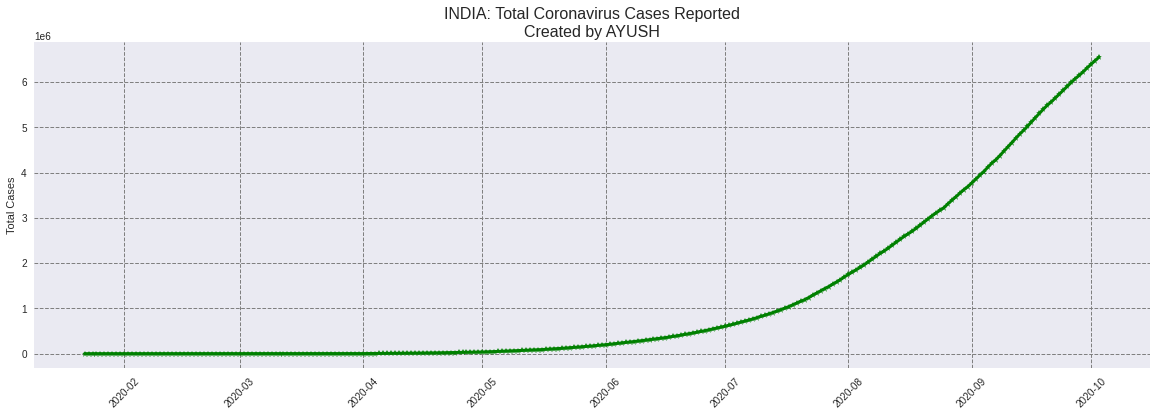

In [ ]:
line_plot("Ayush","seaborn",20,6,"India","green",3,"*")

---

In [ ]:
india_df.tail(7)

State  Confirmed  ...   Latitude  Longitude
31                                    Ladakh       4477  ...  33.945641  77.656858
32               Andaman and Nicobar Islands       3868  ...  10.218834  92.577133
33  Dadra and Nagar Haveli and Daman and Diu       3071  ...  20.717986  70.932399
34                                    Sikkim       3050  ...  27.601029  88.454136
35                                   Mizoram       2120  ...  23.214617  92.868761
36                          State Unassigned          0  ...  48.850208 -54.014322
37                               Lakshadweep          0  ...  10.883277  72.817107

[7 rows x 14 columns]

In [ ]:
folium_map_with_circles("Ayush","India",900,500,20,6,'OpenStreetMap',4,'red',True)

In [ ]:
map=folium_map_with_circles('Ayush','India',900,500,20,6,'OpenStreetMap',4,'red',True)
map.save('/content/Indiamap.html')

In [ ]:
folium_map_with_circles("Ayush","World",900,500,20,6,'OpenStreetMap',2,'red',True)

In [ ]:
map=folium_map_with_circles('Ayush','World',900,500,20,6,'OpenStreetMap',2,'red',True)
map.save('/content/Worldmap.html')

In [ ]:
folium_map_with_circles("Ayush","US",900,500,20,6,'OpenStreetMap',4,'red',True)

In [ ]:
map=folium_map_with_circles('Ayush','US',900,500,20,6,'OpenStreetMap',4,'red',True)
map.save('/content/USmap.html')